In [8]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from math import floor
from scipy.stats import norm

sns.set()
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")
print('<Check the versions of modules>')
print("- Seaborn version : ", sns.__version__)


# load data
with open('train.pickle', 'rb') as f:
    train = pickle.load(f)
with open('test.pickle', 'rb') as f:
    test = pickle.load(f)
    
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')
    
# load the best hyper parameter by tunning 
with open('params_df.pickle', 'rb') as f:
    params_df = pickle.load(f)

<Check the versions of modules>
- Seaborn version :  0.11.1


In [28]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  18
Number of Categorical features:  13


In [40]:
# preset option for model
n_class = 3
n_fold  = 15
seed    = 55

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

# best parameters as result tunning
best_params = params_df.sort_values('value').iloc[0,2:]
best_params.index = ['colsample_bylevel', 'depth', 'learning_rate', 'n_estimators', 'subsample']
best_params = best_params.to_dict()

In [41]:
best_params

{'colsample_bylevel': 0.1832000117969863,
 'depth': 9.0,
 'learning_rate': 0.04160502952238434,
 'n_estimators': 3800.0,
 'subsample': 0.8101208520516356}

In [42]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred      = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats
model_folds = [] 

for fold in range(len(folds)):
    print(f'\n#######################<<< Fold {fold} >>>#######################\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(**best_params,
                                   boosting_type = 'Ordered', 
                                   bootstrap_type = 'Bernoulli')
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)
    model_folds.append(model_cat)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / len(folds)
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tAt total Log Loss: {log_loss(y, cat_pred):.6f}')


#######################<<< Fold 0 >>>#######################

0:	learn: 1.0747908	test: 1.0749221	best: 1.0749221 (0)	total: 23.7ms	remaining: 1m 30s
100:	learn: 0.7284864	test: 0.6988217	best: 0.6988217 (100)	total: 4.67s	remaining: 2m 50s
200:	learn: 0.7158577	test: 0.6792417	best: 0.6792216 (198)	total: 10.1s	remaining: 3m
300:	learn: 0.7101049	test: 0.6748218	best: 0.6748218 (300)	total: 17.4s	remaining: 3m 21s
400:	learn: 0.7006532	test: 0.6723885	best: 0.6723770 (382)	total: 31.8s	remaining: 4m 29s
500:	learn: 0.6904793	test: 0.6712934	best: 0.6712629 (499)	total: 46.1s	remaining: 5m 3s
600:	learn: 0.6818851	test: 0.6701336	best: 0.6701336 (600)	total: 1m	remaining: 5m 19s
700:	learn: 0.6731593	test: 0.6699392	best: 0.6698783 (697)	total: 1m 13s	remaining: 5m 26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6695966175
bestIteration = 747

Shrink model to first 748 iterations.
CV Log Loss Score: 0.669597

#######################<<< Fold 1 >>>###############

CV Log Loss Score: 0.642143

#######################<<< Fold 10 >>>#######################

0:	learn: 1.0745122	test: 1.0748445	best: 1.0748445 (0)	total: 22.7ms	remaining: 1m 26s
100:	learn: 0.7254947	test: 0.6918223	best: 0.6918223 (100)	total: 6.4s	remaining: 3m 54s
200:	learn: 0.7150790	test: 0.6774164	best: 0.6774164 (200)	total: 11.8s	remaining: 3m 31s
300:	learn: 0.7092619	test: 0.6735188	best: 0.6735188 (300)	total: 19.1s	remaining: 3m 41s
400:	learn: 0.6998491	test: 0.6714538	best: 0.6714538 (400)	total: 33.2s	remaining: 4m 41s
500:	learn: 0.6904557	test: 0.6708592	best: 0.6707970 (497)	total: 47.2s	remaining: 5m 10s
600:	learn: 0.6802798	test: 0.6697513	best: 0.6697384 (599)	total: 1m 1s	remaining: 5m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6697384363
bestIteration = 599

Shrink model to first 600 iterations.
CV Log Loss Score: 0.669738

#######################<<< Fold 11 >>>#######################

0:	learn: 1.0745579	test: 1.0744859	best: 1.0

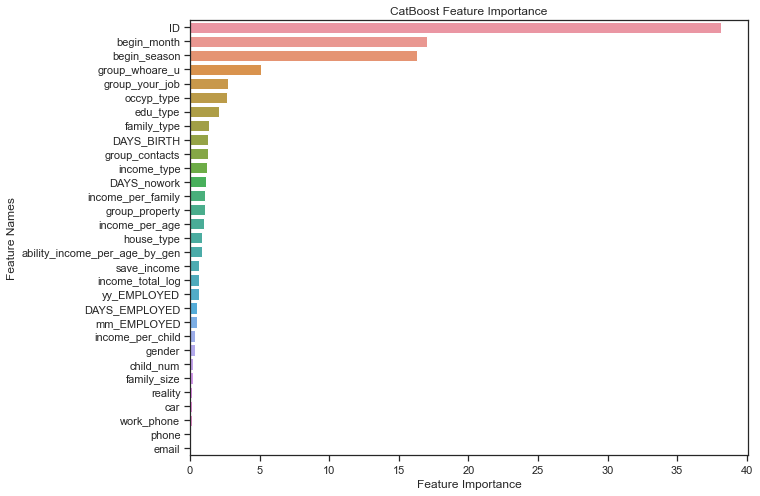

In [43]:
def plot_feature_importance(importance, names):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    feature_importance_df = pd.DataFrame(data)
    
    feature_importance_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=feature_importance_df['feature_importance'], y=feature_importance_df['feature_names'])

    plt.title('CatBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(), X_test.columns)

In [47]:
submit_file = submit.copy()
for i in range(3):
    submit_file[str(i)] = (cat_pred_test)[:,i]

In [48]:
submit_file.set_index('index').apply(np.argmax, axis = 1).value_counts(normalize = True)

2    0.8096
1    0.1413
0    0.0491
dtype: float64

In [49]:
submit_file.head(20)

,index,0,1,2
0,26457,0.102441,0.161195,0.736363
1,26458,0.325267,0.234073,0.440660
2,26459,0.040754,0.070980,0.888266
3,26460,0.054879,0.085828,0.859293
4,26461,0.078146,0.215168,0.706685
5,26462,0.053115,0.124809,0.822075
6,26463,0.608725,0.379271,0.012004
7,26464,0.049257,0.085210,0.865533
8,26465,0.063274,0.095781,0.840945
9,26466,0.061463,0.282587,0.655950


In [50]:
# save the submit file
save_file_path = '/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/'
submit_file.to_csv(save_file_path + 'submit_file.csv', index = False)